# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from scipy.sparse import hstack
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#selecting a random sample of 10000 points from the 500000 poins

In [4]:
# we are forming a dataset with 100000 points
filtered_data=filtered_data.sample(n=100000, random_state=1)

In [5]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
352806,381628,B005WWYY2Q,A2G88IFSSK591Y,Teacher Mom,1,1,1,1345420800,"Great card, okay chocolate",While I think that the wizard card that accomp...
417824,451841,B00004CXX9,A4RUN01NO4827,myownme777,0,0,1,1125878400,burton's best?,Tim Burton's fantastic vision of life after de...
469847,508086,B006N3IE6A,A2WBPNC46MMHYV,"Ceil ""ceilmary""",0,0,1,1307059200,Great coffee,I love Jamaica Me Crazy coffee. This version i...
407746,440916,B005VOONM6,A2GKWC2UIDRZ42,Daysong Reflections,0,0,1,1332288000,Marley One Love Organic Coffee,I have not always been a coffee drinker but ha...
469848,508088,B006N3IE6A,A38S7IRMROBB9C,BostonFrankG,0,0,1,1306713600,A Good Daily Roast,This coffee has become one of my daily favorit...


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [11]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(86847, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

86.847

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(86846, 10)


1    73352
0    13494
Name: Score, dtype: int64

# Getting the length of each review 

In [17]:
l = []
def length(p):
    x=len(p)
    return x
for sentence in tqdm(final['Text'].values):
    y=length(sentence)
    l.append(y)

100%|████████████████████████████████| 86846/86846 [00:00<00:00, 374329.10it/s]


In [18]:
final['length']=l

In [19]:
final.shape

(86846, 11)

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [20]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!
I paid way more for this than the current sale price at my local pet store ($26).  My bull terrier puppy had surgery yesterday and we were struggling to find something to turn his attention away from the stitches.  I put treats through the other side and only put one of the treat balls on the one end, saving the second for later.  He did manage to finally dislodge the treat, but even eating that took longer than his Booda Bimples.  So overall I'm very happy.  After he finished the treat on the outside, he had to find a way to get the other treats on the inside.  He's a 50# bull terrier

'If you are looking for a healthy alternative for potatoes or noodles or white rice, Hodgson\'s whole wheat couscous is it. After you boil the water it takes 5 minutes of standing and that\'s it. You can add ingredients to "spice" it up. I wasn\'t able to find it in my local stores so I am very happy to find it on Amazon..<a href=" Mill Whole Wheat Couscous, 11-Ounce Units (Pack of 8)</a>'

In [21]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!


In [21]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books & songs when I did my  student teaching for preschoolers & turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &  2.  The tradition lives on!
I paid way more for this than the current sale price at my local pet store ($26).  My bull terrier puppy had surgery yesterday and we were struggling to find something to turn his attention away from the stitches.  I put treats through the other side and only put one of the treat balls on the one end, saving the second for later.  He did manage to finally dislodge the treat, but even eating that took longer than his Booda Bimples.  So overall I'm very happy.  After he finished the treat on the outside, he had to find a way to get the other treats on the inside.  He's a 50# bull terrier puppy, and 

In [22]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Received this as a holiday gift, if you are in love with rum you should like this cake. It is nice and moist and has a pungent aroma of rum. It is made in the Cayman Islands. My dog was at first, slightly repelled by the smell but now it is following me around!


In [24]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children  &amp;    The tradition lives on!


In [25]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Received this as a holiday gift if you are in love with rum you should like this cake It is nice and moist and has a pungent aroma of rum It is made in the Cayman Islands My dog was at first slightly repelled by the smell but now it is following me around 


In [26]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [27]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████| 86846/86846 [02:02<00:00, 710.81it/s]


In [28]:
score=final['Score'].values

In [29]:
#Forming a dataframe with preprocessed reviews and the length of the reviews
data=pd.DataFrame(preprocessed_reviews, columns = ['text'])
data['length']=final['length'].values

In [30]:
data.head(5)

,text,length
0,remember seeing show aired television years ag...,407
1,twist rumplestiskin captured film starring mic...,222
2,one movie movie collection filled comedy actio...,131
3,getting crazy looking beatlejuice french versi...,199
4,beetlejuice awe inspiring wonderfully amusing ...,2075


# Code for dividing the data into train and test

In [31]:
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
X_1, X_test, y_1, y_test = cross_validation.train_test_split(data, score, test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

C:\Users\Neelu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# [4] Featurization

## [4.1] BAG OF WORDS

In [32]:
# Please write all the code with proper documentation
count_vect = CountVectorizer() 
bag_counts = count_vect.fit_transform(X_tr['text'].values)
testvalues=count_vect.transform(X_test['text'].values)
cvvalues=count_vect.transform(X_cv['text'].values)

In [33]:
##merging Bow, length of text features
 
a=np.array(X_tr['length'])
b=np.array(X_cv['length'])
c=np.array(X_test['length'])

train=a.reshape(len(a),1)
cv=b.reshape(len(b),1)
test=c.reshape(len(c),1)

train_data = hstack((bag_counts,train))
test_data = hstack((testvalues,test))
cv_data= hstack((cvvalues,cv))

## [4.3] TF-IDF

In [34]:
tf_idf_vect = TfidfVectorizer()
train_tfidf_text = tf_idf_vect.fit_transform(X_tr['text'].values)
cv_tfidf_text=tf_idf_vect.transform(X_cv['text'].values)
test_tfidf_text=tf_idf_vect.transform(X_test['text'].values)

In [35]:
## merging tfidf vectors and length of the reviews
train_data_tfidf = hstack((train_tfidf_text,train))
test_data_tfidf = hstack((test_tfidf_text,test))
cv_data_tfidf= hstack((cv_tfidf_text,cv))

In [37]:
type(train_data_tfidf)

scipy.sparse.coo.coo_matrix

# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using absolute values of `coef_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Code for Confusion matrix construction

In [38]:
##Code for Confusion matrix construction
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    
    B =(C/C.sum(axis=0))
    
    
    labels = [0,1]
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
   
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

the auc score for each alpha value is :  [0.7945 0.8187 0.8477 0.8797 0.9064 0.9013 0.5749 0.5    0.5   ]
the auc score for cv data for each alpha value is :  [0.7392 0.7675 0.8024 0.8441 0.8849 0.8339 0.5097 0.5002 0.5   ]

The optimal alpha is. 0.1


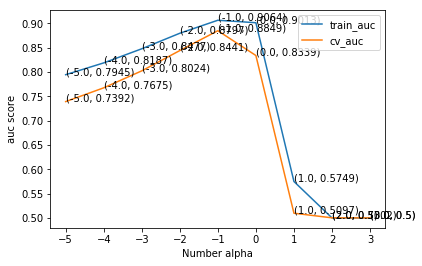

For values of best alpha =  0.1 The train auc is: 97.44435220660334
For values of best alpha =  0.1 The cross validation auc is: 90.60291378665866
For values of best alpha =  0.1 The test  auc is: 90.69190387599167


In [116]:
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1,10,100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    
    clf = MultinomialNB(alpha=i)
    clf.fit(train_data, y_tr)
    
    
    
    
    
    scores_train = cross_val_score(clf, train_data, y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(clf, cv_data, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())

# determining best alpha
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()





best_alpha = optimal_alpha
clf = MultinomialNB(alpha=best_alpha)   ### training the model with the best alpha value
clf.fit(train_data, y_tr)


predict_y = clf.predict_proba(train_data)[:,1]
acc = roc_auc_score(y_tr, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The train auc is:",acc) ### auc score for train data using best alpha value
predict_y = clf.predict_proba(cv_data)[:,1]
acc =roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The cross validation auc is:",acc) ### auc score for cv data using best alpha value
predict_y = clf.predict_proba(test_data)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The test  auc is:",acc) ### auc score for test data using best alpha value

# construction of confusion matrix

-------------------- Confusion matrix --------------------


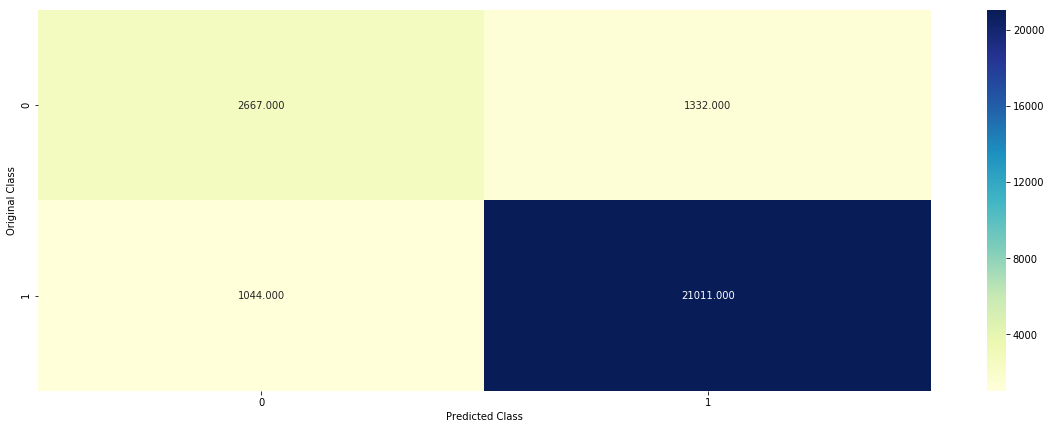

-------------------- Precision matrix (Columm Sum=1) --------------------


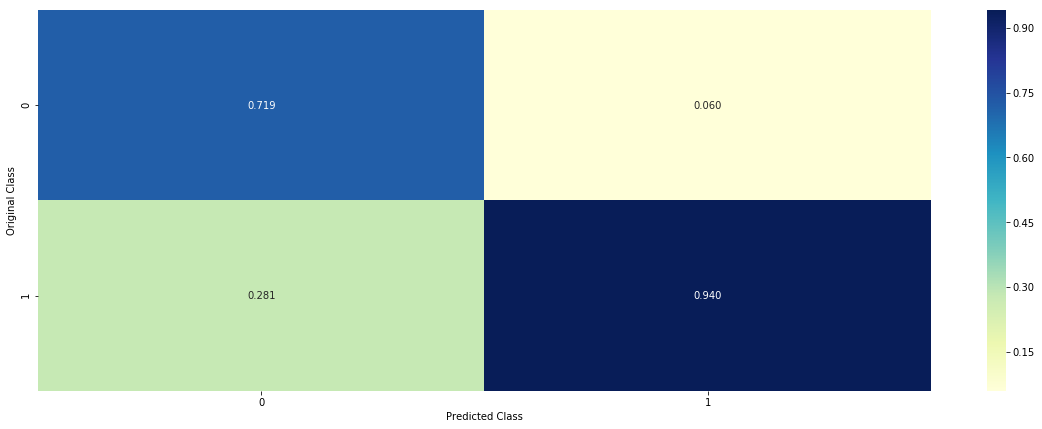

-------------------- Recall matrix (Row sum=1) --------------------


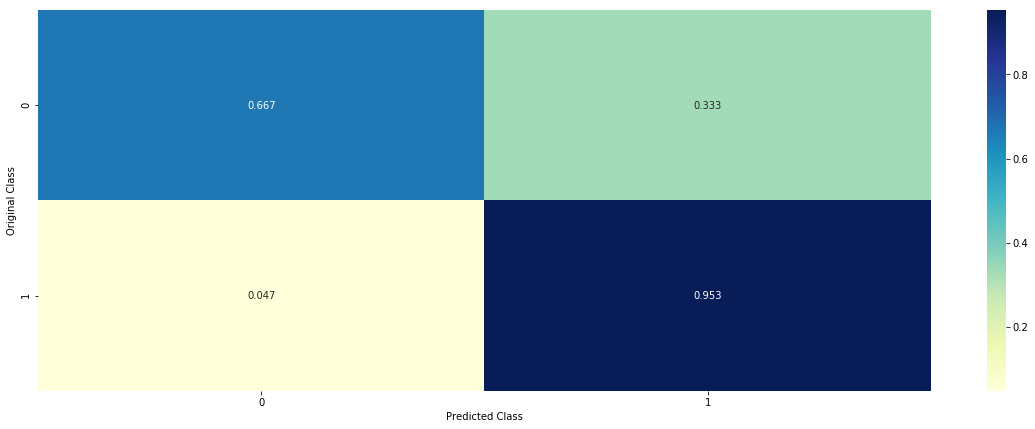

In [105]:
predict_y = clf.predict(test_data)

plot_confusion_matrix(y_test, predict_y)

# Code for extraction of important features

In [106]:
##Code for arranging the feature_log_prob_ in descending order
coef0 = clf.feature_log_prob_[0]
coef1=clf.feature_log_prob_[1]

#coef0=coef0-coef1
#coef1=coef1-coef0
features=count_vect.get_feature_names()
features0=zip(coef0, features)

values0=sorted(features0,reverse=True)[:20]
features1=zip(coef1,features)
values1=sorted(features1,reverse=True)[:20]
indices0=np.argsort(features0)
indices1=np.argsort(features1)



### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [107]:
for cff,feature in values1:
    print("feature: %s" %(feature))


feature: not
feature: like
feature: good
feature: great
feature: one
feature: taste
feature: coffee
feature: love
feature: flavor
feature: would
feature: tea
feature: product
feature: food
feature: get
feature: no
feature: really
feature: use
feature: amazon
feature: also
feature: best


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [108]:
for cff,feature in values0:
    print("feature: %s" %(feature))

feature: not
feature: like
feature: product
feature: would
feature: taste
feature: one
feature: coffee
feature: flavor
feature: good
feature: no
feature: tea
feature: food
feature: even
feature: amazon
feature: get
feature: buy
feature: much
feature: really
feature: box
feature: tried


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

the auc score for each alpha value is :  [0.7906 0.8188 0.8538 0.8894 0.9057 0.6695 0.4657 0.4999 0.5   ]
the auc score for cv data for each alpha value is :  [0.7484 0.7803 0.8229 0.8712 0.8745 0.5413 0.4763 0.5002 0.5   ]


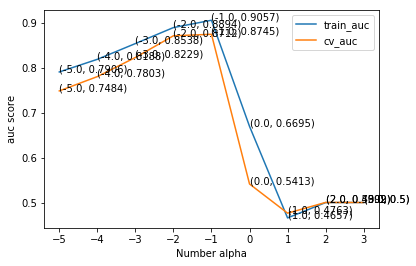

For values of best alpha =  0.1 The train auc is: 97.42431718656925
For values of best alpha =  0.1 The cross validation auc score is: 92.00118738435853
For values of best alpha =  0.1 The test  auc score is: 92.12571846203448


In [115]:
# Please write all the code with proper documentation
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1,10,100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    
    clf_tfidf = MultinomialNB(alpha=i)
    clf_tfidf.fit(train_data_tfidf, y_tr)
    scores = cross_val_score(clf_tfidf, train_data_tfidf, y_tr, cv=10, scoring='roc_auc')
    cv_scores.append(scores.mean())

    
    scores_train = cross_val_score(clf_tfidf, train_data_tfidf, y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(clf_tfidf, cv_data_tfidf, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())

# determining best alpha
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]
# determining best alpha
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()



best_alpha = optimal_alpha
clf_tfidf = MultinomialNB(alpha=best_alpha) ### training the model with the best alpha value
clf_tfidf.fit(train_data_tfidf, y_tr)


predict_y = clf_tfidf.predict_proba(train_data_tfidf)[:,1]
ftrain=roc_auc_score(y_tr, predict_y)*100  ### auc score for train data using best alpha value
print('For values of best alpha = ', best_alpha, "The train auc is:",ftrain)
predict_y = clf_tfidf.predict_proba(cv_data_tfidf)[:,1]
fcv=roc_auc_score(y_cv, predict_y)*100  ### auc score for cv data using best alpha value
print('For values of best alpha = ', best_alpha, "The cross validation auc score is:",fcv)
predict_y = clf_tfidf.predict_proba(test_data_tfidf)[:,1]
ftest=roc_auc_score(y_test, predict_y)*100  ### auc score for test data using best alpha value

print('For values of best alpha = ', best_alpha, "The test  auc score is:",ftest)

# Construction of confusion matrix on test data

-------------------- Confusion matrix --------------------


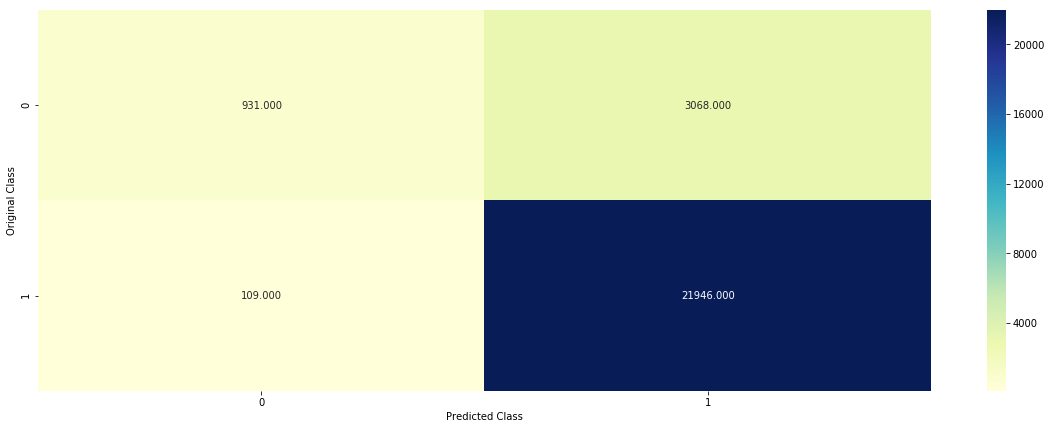

-------------------- Precision matrix (Columm Sum=1) --------------------


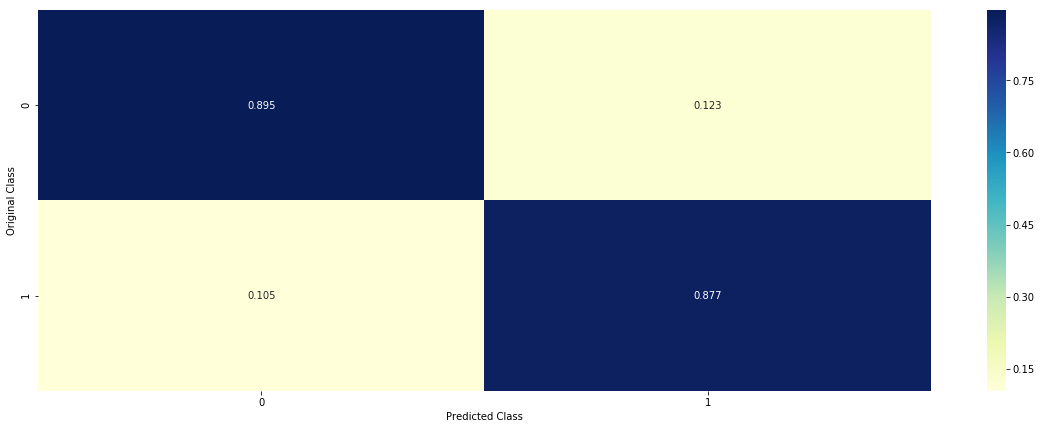

-------------------- Recall matrix (Row sum=1) --------------------


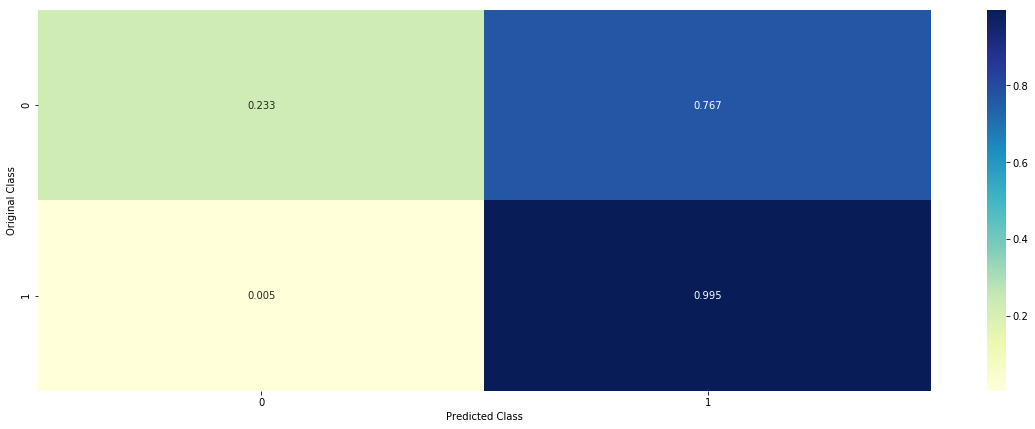

In [110]:
predict_y = clf_tfidf.predict(test_data_tfidf)

plot_confusion_matrix(y_test, predict_y)

# Code for extraction of important features

In [111]:
##Code for arranging the feature_log_prob_ in descending order
coef00 = clf_tfidf.feature_log_prob_[0]
coef11=clf_tfidf.feature_log_prob_[1]
#coef00=coef00-coef11
#coef11=coef11-coef00
features=count_vect.get_feature_names()
features00=zip(coef00, features)

values00=sorted(features00,reverse=True)[:20]
features11=zip(coef11,features)
values11=sorted(features11,reverse=True)[:20]
indices00=np.argsort(features00)
indices11=np.argsort(features11)





### [5.2.1] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [112]:
for cff,feature in values00:
    print("feature: %s" %(feature))

feature: not
feature: like
feature: taste
feature: product
feature: would
feature: coffee
feature: one
feature: flavor
feature: tea
feature: no
feature: good
feature: even
feature: buy
feature: box
feature: bad
feature: amazon
feature: food
feature: get
feature: disappointed
feature: could


### [5.2.2] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [113]:
# Please write all the code with proper documentation
for cff,feature in values11:
    print("feature: %s" %(feature))

feature: not
feature: great
feature: good
feature: coffee
feature: like
feature: love
feature: tea
feature: taste
feature: product
feature: one
feature: flavor
feature: would
feature: best
feature: food
feature: price
feature: really
feature: get
feature: amazon
feature: use
feature: find


# [6] Conclusions

In [114]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC_train","AUC_CV","AUC_test"]
x.add_row(["BOW", "Multinomial NB",0.1 ,97.44435220660334,90.60291378665866,90.69190387599167])
x.add_row(["TF-IDF", "Multinomial NB", 0.1,97.42431718656925,92.00118738435853,92.12571846203448])
print(x)



+------------+----------------+----------------+-------------------+-------------------+-------------------+
| Vectorizer |     Model      | Hyperparameter |     AUC_train     |       AUC_CV      |      AUC_test     |
+------------+----------------+----------------+-------------------+-------------------+-------------------+
|    BOW     | Multinomial NB |      0.1       | 97.44435220660334 | 90.60291378665866 | 90.69190387599167 |
|   TF-IDF   | Multinomial NB |      0.1       | 97.42431718656925 | 92.00118738435853 | 92.12571846203448 |
+------------+----------------+----------------+-------------------+-------------------+-------------------+
